In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [2]:
votes_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")
school_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_group.parquet")

In [3]:
master_df = pd.read_csv("/home/sprintda05/final/최종 마스터 테이블(8일차)v2.csv")

In [4]:
# 날짜 정제
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.date

# 해당 기간(4/28 ~ 5/25)에 투표한 유저 ID
target_user_ids = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-29").date()) &
    (votes_df["vote_date"] <= pd.to_datetime("2023-05-25").date())
]["user_id"].unique()

# school_id가 존재하는 group만 추출
school_df_valid = school_df[school_df["school_id"].notnull()].copy()

# school_id를 유저에게 붙이기 (users → school_df)
users_with_school = users_df.merge(
    school_df_valid[["id", "school_id"]],
    left_on="group_id", right_on="id", how="left"
).drop(columns="id_y").rename(columns={"id_x": "user_id"})

# 해당 유저 중에서 위 기간에 투표한 유저만 필터링
target_users = users_with_school[users_with_school["user_id"].isin(target_user_ids)]

# 투표한 유저가 소속된 학교 ID들 (유니크)
active_school_ids = target_users["school_id"].dropna().unique()
print(" 해당 기간에 투표 발생한 학교 수:", len(active_school_ids))

# 이 학교 ID에 속한 전체 유저 수
final_user_count = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].nunique()

print(" 해당 학교에 소속된 유저 수:", final_user_count)

 해당 기간에 투표 발생한 학교 수: 10
 해당 학교에 소속된 유저 수: 5090


In [5]:
# 해당 학교에 속한 유저 ID 목록
target_school_user_ids = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].unique()

# 해당 유저 중에서 4/28 ~ 5/25 기간에 투표한 유저 수
voted_users_in_target_schools = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-29").date()) &
    (votes_df["vote_date"] <= pd.to_datetime("2023-05-25").date()) &
    (votes_df["user_id"].isin(target_school_user_ids))
]["user_id"].nunique()

print(" 해당 10개 학교 유저 중 실제 투표한 유저 수:", voted_users_in_target_schools)

 해당 10개 학교 유저 중 실제 투표한 유저 수: 4703


In [6]:
# 1. vote_date 다시 파싱
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.normalize()

# 2. master_df 기준 유저 ID만 사용
cohort_users = master_df[["user_id", "first_vote"]].copy()
cohort_users.rename(columns={"first_vote": "cohort_day"}, inplace=True)
cohort_users["cohort_day"] = pd.to_datetime(cohort_users["cohort_day"])

# 3. votes_df에서 해당 유저만 필터링
votes_filtered_df = votes_df[votes_df["user_id"].isin(cohort_users["user_id"])].copy()

# 4. cohort_day 붙이기
votes_filtered_df = votes_filtered_df.merge(cohort_users, on="user_id", how="left")

# 5. active_day 계산
votes_filtered_df["active_day"] = (votes_filtered_df["vote_date"] - votes_filtered_df["cohort_day"]).dt.days
votes_filtered_df = votes_filtered_df[votes_filtered_df["active_day"] >= 0]

# 6. cohort_size 다시 계산
cohort_size_df = cohort_users.groupby("cohort_day")["user_id"].nunique().reset_index(name="cohort_size")

# 7. active_day별 유지 유저 수
retained_df = votes_filtered_df.groupby(["cohort_day", "active_day"])["user_id"] \
    .nunique().reset_index(name="retained")

# 8. 리텐션율 계산
ret_df = retained_df.merge(cohort_size_df, on="cohort_day")
ret_df["rate"] = ret_df["retained"] / ret_df["cohort_size"]


In [7]:
ret_df["rate"]

0       1.000000
1       0.954751
2       0.837104
3       0.904977
4       0.773756
          ...   
2079    0.032258
2080    0.032258
2081    0.032258
2082    0.032258
2083    0.032258
Name: rate, Length: 2084, dtype: float64

In [8]:
cohort_size_df

,cohort_day,cohort_size
0,2023-04-29,221
1,2023-04-30,114
2,2023-05-01,37
3,2023-05-02,73
4,2023-05-03,384
5,2023-05-04,167
6,2023-05-05,436
7,2023-05-06,183
8,2023-05-07,105
9,2023-05-08,149


In [ ]:
# 리텐션율 계산 완료 후
ret_df["rate"] = ret_df["retained"] / ret_df["cohort_size"]

# 30일 이상은 제외
ret_df = ret_df[ret_df["active_day"] <= 30]

#피벗 테이블
retention = ret_df.pivot(index="cohort_day", columns="active_day", values="rate")

#cohort_size 붙이기
retention = cohort_size_df.set_index("cohort_day").join(retention)

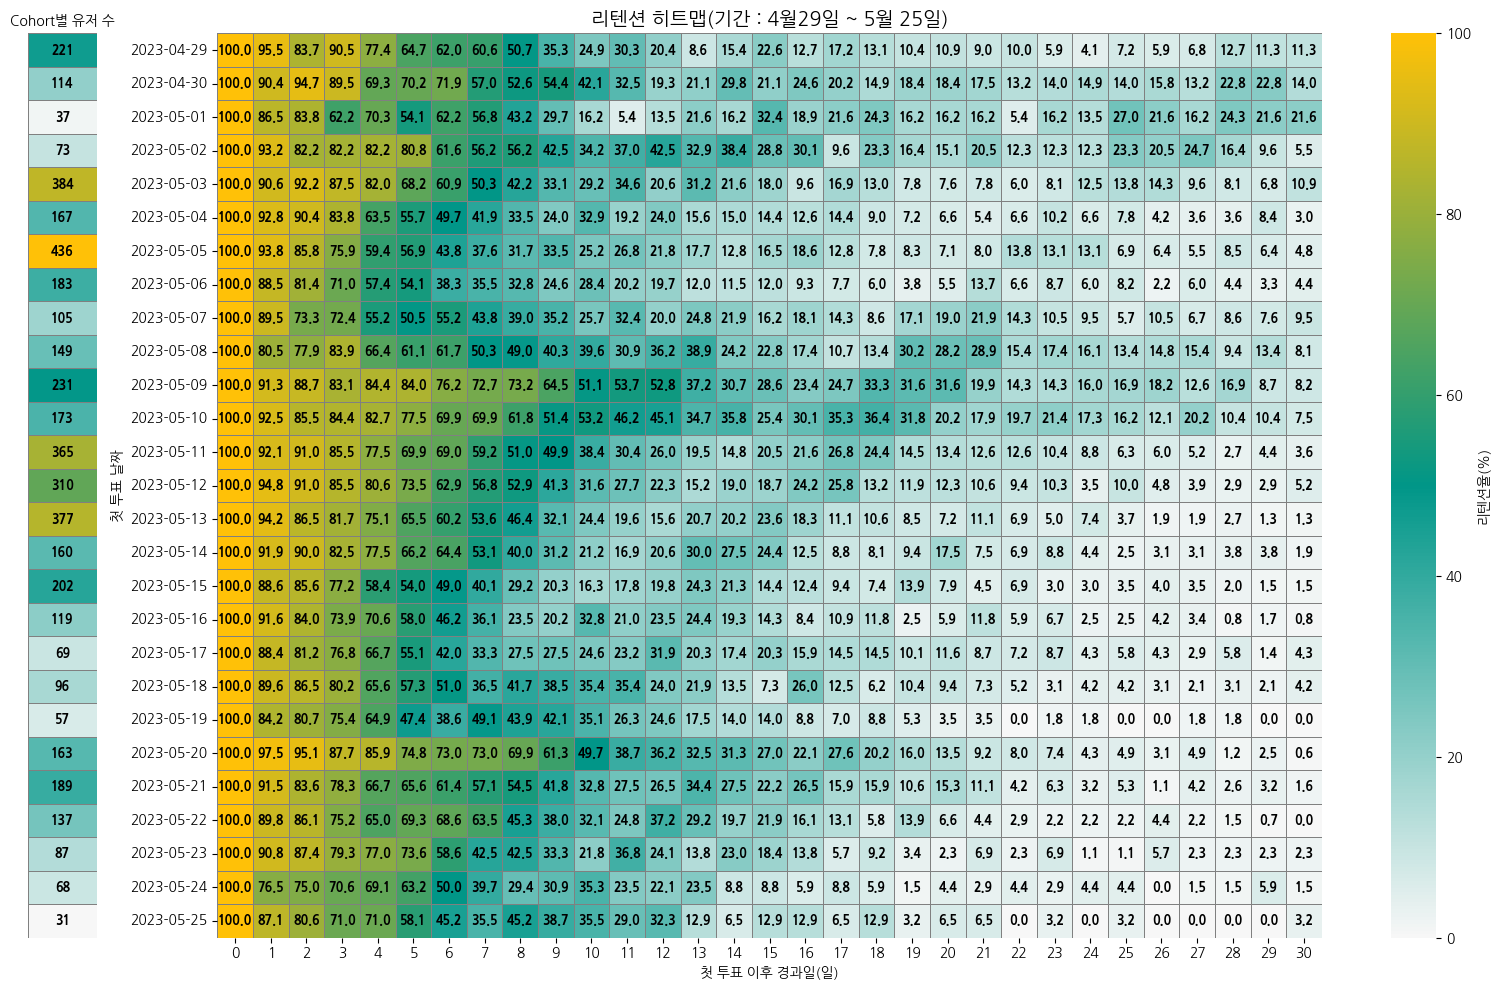

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# 피벗 테이블 만들기
# 리텐션율 테이블
retention = ret_df.pivot(index="cohort_day", columns="active_day", values="rate").fillna(0)

# cohort_size 추가 (좌측 히트맵용)
cohort_sizes = ret_df.drop_duplicates("cohort_day")[["cohort_day", "cohort_size"]].set_index("cohort_day")

#  컬러맵 정의
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ['#f7f7f7', '#009688', '#ffc107'])

#  인덱스 문자열 통일
retention.index = pd.to_datetime(retention.index).strftime('%Y-%m-%d')
cohort_sizes.index = pd.to_datetime(cohort_sizes.index).strftime('%Y-%m-%d')

# 서브플롯 구성
fig, (ax0, ax1) = plt.subplots(
    ncols=2,
    figsize=(16, 10),
    gridspec_kw={'width_ratios': [0.3, 6]} 
)

# Cohort Size 히트맵
sns.heatmap(
    cohort_sizes,
    ax=ax0,
    annot=True, fmt="d", cmap=custom_cmap,
    annot_kws={"weight": "bold","color": "black", "size": 9},
    linewidths=0.5, linecolor='gray',
    cbar=False,
    yticklabels=False,
    xticklabels=False
)
ax0.set_ylabel("")
ax0.set_xlabel("")
ax0.set_title("Cohort별 유저 수", fontsize=10)

#Retention 히트맵
sns.heatmap(
    retention * 100,  # 퍼센트
    ax=ax1,
    annot=True, fmt=".1f", cmap=custom_cmap,
    annot_kws={"weight": "bold", "color": "black", "size": 9},
    linewidths=0.5, linecolor='gray',
    cbar_kws={'label': '리텐션율(%)'}
)
ax1.set_title("리텐션 히트맵(기간 : 4월29일 ~ 5월 25일)", fontsize=14)
ax1.set_xlabel("첫 투표 이후 경과일(일)")
ax1.set_ylabel("첫 투표 날짜")
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)


#전체 정렬
plt.tight_layout()
plt.show()


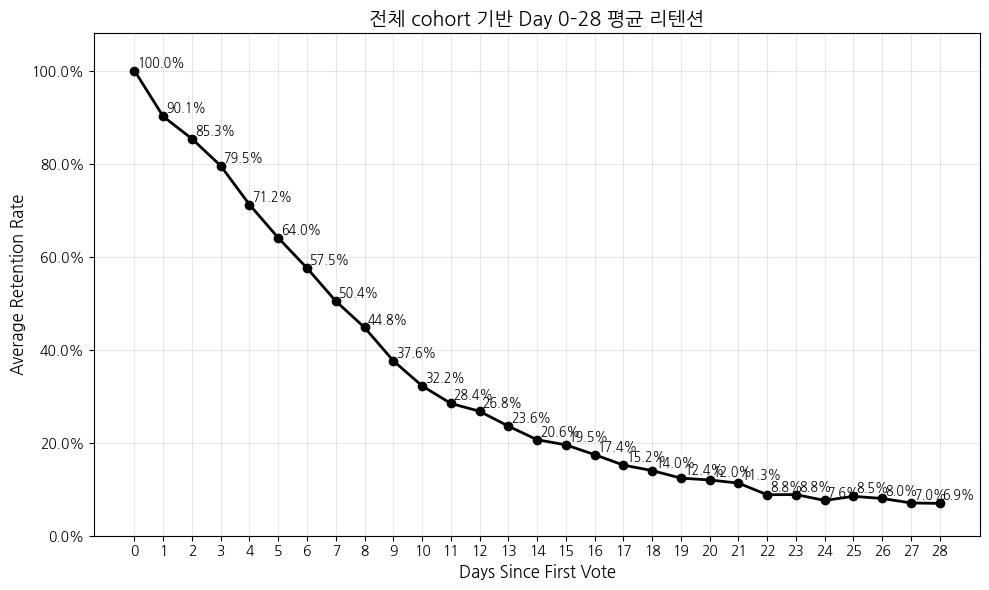

In [13]:
from matplotlib import ticker

# 평균 리텐션 계산 (Day 0~28)
avg_retention = (
    ret_df[ret_df["active_day"] <= 28]
    .groupby("active_day")["rate"]
    .mean()
    .reset_index()
)

# 라인 그래프 
plt.figure(figsize=(10, 6))
plt.plot(
    avg_retention["active_day"],
    avg_retention["rate"],
    marker="o",
    color="#000000",  #
    linewidth=2,
    label="평균 리텐션율"
)

# 각 점 위에 수치 표시
# 수치 표시를 좀 더 보기 좋게 띄워서 추가
for x, y in zip(avg_retention["active_day"], avg_retention["rate"]):
    plt.text(x + 0.1, y + 0.03, f"{y:.1%}", ha="left", va="top", fontsize=9, color="#000000")



# 레이블/그리드/포맷 설정
plt.xticks(range(0, 29))
plt.xlabel("Days Since First Vote", fontsize=12)
plt.ylabel("Average Retention Rate", fontsize=12)
plt.title("전체 cohort 기반 Day 0–28 평균 리텐션", fontsize=14)
plt.grid(alpha=0.3)
plt.ylim(0, 1.08)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
plt.tight_layout()
plt.show()